![Tolkie and SIDN Fonds logo](https://raw.githubusercontent.com/Tolkie-NL/explanatory-images/main/tolkie-sidn-logos.png)
# Generating Explanatory Images for the Tolkie project

This page describes the learnings from generating images for concepts for the Tolkie project. 

## About Tolkie

In The Netherlands around 2.5 million people aged 16 and older are considered low-literate. They have a hard time reading, writing or basic calculations. This means that 1 in 6 adults have trouble reading government letters, the news, terms and conditions, etc. At [Tolkie](https://tolkie.nl/) we provide organisations with tools to make their online written content accessible to this group of people. We do this by providing simple summaries for texts and reading aid for difficult words in the form of definitions, translations, a button to read the word aloud and images. These images are currently selected manually from online image libraries. With the help of the [SIDN Fonds](https://www.sidnfonds.nl/) we wanted to see whether it is possible to use the upcoming abilities of large language models to automatically generate images that explain difficult words (or generally all words).

## Process

We have experimented with various ways to acquire images. First, we have connected to an existing (Google) API to download images of concepts. The results were unsatisfying, so we changed the approach to creating images with the generative AI solution Stable Diffusion. 

### Initial approach: static prompts
First, we have created static prompts to generate images. In order to run the code on this page, you need a key for the Stable Diffusion API. You can find details here https://platform.stability.ai/docs/getting-started/credits-and-billing . This first code fragment creates a general function for calling the stability_sdk.

In [1]:
import io
import warnings

from PIL import Image
from stability_sdk import client

import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation

print("Please enter API key...")
STABILITY_KEY = input("Enter the stability key: ")

def generate_image(prompt: str) -> Image:
    stability_api = client.StabilityInference(
        key=STABILITY_KEY,  # API Key reference.
        verbose=True,  # Print debug messages.
        engine="stable-diffusion-xl-1024-v1-0",  # Set the engine to use for generation.
    )

    # Set up our initial generation parameters.
    answers = stability_api.generate(
        prompt=prompt,
        steps=50,  # Amount of inference steps performed on image generation. Defaults to 30.
        cfg_scale=8.0,  # Influences how strongly your generation is guided to match your prompt.
        width=1024,  # Generation width, defaults to 512 if not included.
        height=1024,  # Generation height, defaults to 512 if not included.
        samples=1,  # Number of images to generate, defaults to 1 if not included.
        sampler=generation.SAMPLER_K_DPMPP_2M  # Choose which sampler we want to denoise our generation with.
    )

    for resp in answers:
        for artifact in resp.artifacts:
            if artifact.finish_reason == generation.FILTER:
                warnings.warn(
                    "Your request activated the API's safety filters and could not be processed."
                    "Please modify the prompt and try again."
                )
            if artifact.type == generation.ARTIFACT_IMAGE:
                image = Image.open(io.BytesIO(artifact.binary))
                return image

    return None

print("Initialized.")


Please enter API key...
Initialized.


### Static prompts
Next, we used different kinds of static prompts to experiment with generating images. In this example, the word "bank" is used:

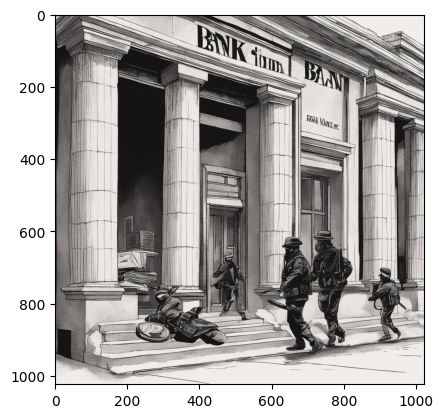

In [2]:
import matplotlib.pyplot as plt

def create_static_image(prompt: str):
    image = generate_image(prompt=prompt)
    if image:
        plt.imshow(image)

word = "bank"
text = "the robbers robbed the bank and ran away with the money"
prompt = f"{word} in the context of '{text}'"

create_static_image(prompt=prompt)


Sometimes this lead to good results. However, with some more conceptual words this approach was insufficient:

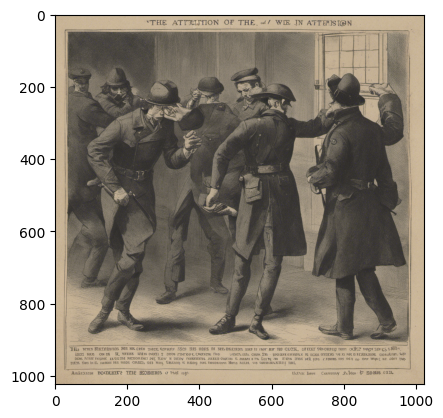

In [3]:
word = "attention"
text = "the attention of the robbers was at the police as they were assumed to be arriving soon"

prompt = f"{word} in the context of '{text}'"

create_static_image(prompt=prompt)


### Dynamic generation of prompts for Stable Diffusion
To cope with the problems above, the next approach was to create the images in a 2-way step by first asking an LLM (GPT3) to generate the right prompts.

A clipart vector drawing of a building with a dollar sign on it to visually represent [bank]. White background.


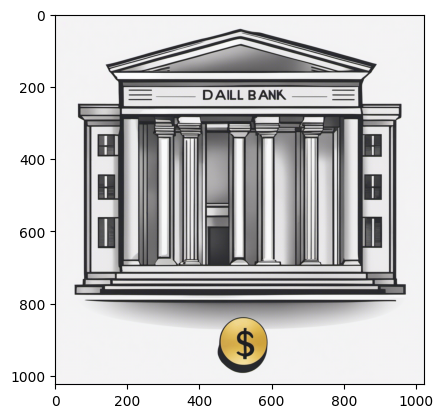

In [4]:
import openai
import traceback

OPENAI_KEY = input("Enter the OpenAI key: ")
openai.api_key = OPENAI_KEY

def call_openai_api(prompt_text: str, max_tokens: int = 50) -> str:
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt_text}],
            temperature=0,
            max_tokens=max_tokens,
            n=1,
        )

        return response.choices[0]["message"]["content"].strip().strip('"').strip("!")

    except Exception as e:
        print(prompt_text)
        print(e)
        traceback.print_exc()
        return None

    
def create_prompt_for_image_generation(word: str, context: str) -> str:
    prompt_text = f"""
        ### **Instructions**
        1. **Translate** the word _X_ using context _Y_ to English, producing _Z_.
        2. **Categorize** _Z_ into 'Physical Objects', 'Tangible Concepts', or 'Symbolic Concepts', producing _C_.
        3. **Provide a Visual Guide** based on _Y_ for _Z_, producing _D_.
        4. **Combine** _C_ and _D_ into a final **Illustration Directive**.

        ### **Rules for Guidance D**:

        - **Absolutely NO**: words, punctuation, question marks, numbers, dice pips, speech bubbles, thought bubbles, or visual effects.
        - Imagery should avoid being too literal where forbidden elements might be tempting to use.
        - Must be clear and easily understood.

        ### **Output Formula**:

        - If _C_ is "Physical Objects": "A clipart vector drawing of _D_ to visualize [Z]. White background."
        - If _C_ is "Tangible Concepts": "A clipart vector drawing of _D_ to represent the concept of [Z]. White background."
        - If _C_ is "Symbolic Concepts": "A clipart vector drawing of _D_ to symbolize [Z]. White background."

        ### **Examples**:

        **Input**: _X_ = "Huurachterstand", _Y_ = "Een huurachterstand betekent dat iemand de huur van zijn huis niet op tijd heeft betaald en nu geld schuldig is aan de verhuurder."

        **Output**: "A clipart vector drawing of a house with a clock and money to visually represent the concept of [rent arrears]. White background."

        **Input**: _X_ = "Geheugen", _Y_ = "Het vermogen om vroegere ervaringen of kennis te herinneren."

        **Output**: "A clipart vector drawing of a brain intertwined with a faded calendar page to symbolize [memory]. White background."

        **Input**: _X_ = "Communicatie", _Y_ = "Het proces van informatie overbrengen tussen individuen."

        **Output**: "A clipart vector drawing of two people facing each other with abstract sound waves between them to symbolize [communication]. White background."

        ### **IMPORTANT**:
        Only provide the final output without additional explanations, the word 'output', or process breakdown.

        ### **Input**:
        The **Input** is: _X_ = "{word}", _Y_ = "{context}"
    """

    return call_openai_api(prompt_text, max_tokens=1000)

word = "bank"
text = "the robbers robbed the bank and ran away with the money"

prompt = create_prompt_for_image_generation(word, text)
print(prompt)

create_static_image(prompt=prompt)



And again for the case of 'attention':

A clipart vector drawing of robbers looking towards a police car to visually represent the concept of [attention]. White background.


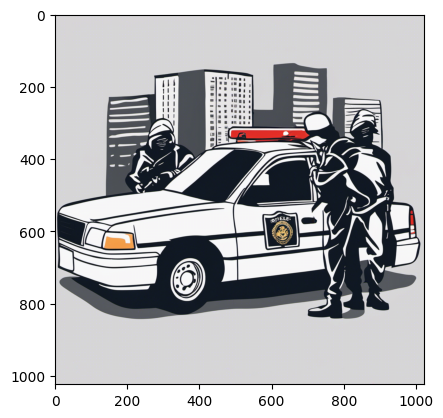

In [5]:
word = "attention"
text = "the attention of the robbers was at the police as they were assumed to be arriving soon"

prompt = create_prompt_for_image_generation(word, text)
print(prompt)

create_static_image(prompt=prompt)

While the first images showed promising results, the style if the images was dark and sometimes grim. 
Therefor we have experimented with different styles. The following code fragment shows the same prompt as above, but with a different style:

In [6]:
def create_prompt_for_image_generation(word: str, context: str) -> str:
    prompt_text = f"""
        ### **Instructions**
        1. **Translate** the word _X_ using context _Y_ to English, producing _Z_.
        2. **Categorize** _Z_ into 'Physical Objects', 'Tangible Concepts', or 'Symbolic Concepts', producing _C_.
        3. **Provide a Visual Guide** based on _Y_ for _Z_, producing _D_.
        4. **Combine** _C_ and _D_ into a final **Illustration Directive**.
        
        ### **Rules for Guidance D**:
        
        - **Absolutely NO**: words, punctuation, question marks, numbers, dice pips, speech bubbles, thought bubbles, or visual effects.
        - Imagery should avoid being too literal where forbidden elements might be tempting to use.
        - Must be clear and easily understood.
        
        ### **Output Formula**:
        
        - If _C_ is "Physical Objects": "Friendly colored simple drawing on a white background of _D_ to visualize [Z]."
        - If _C_ is "Tangible Concepts": "Friendly colored simple drawing on a white background of _D_ to represent the concept of [Z]."
        - If _C_ is "Symbolic Concepts": "Friendly colored simple drawing on a white background of _D_ to symbolize [Z]."
        
        ### **Examples**:
        
        **Input**: _X_ = "Huurachterstand", _Y_ = "Een huurachterstand betekent dat iemand de huur van zijn huis niet op tijd heeft betaald en nu geld schuldig is aan de verhuurder."
        
        **Output**: "Friendly colored simple drawing on a white background of a house with a clock and money to visually represent the concept of [rent arrears]. White background."
        
        **Input**: _X_ = "Geheugen", _Y_ = "Het vermogen om vroegere ervaringen of kennis te herinneren."
        
        **Output**: "Friendly colored simple drawing on a white background of a brain intertwined with a faded calendar page to symbolize [memory]."
        
        **Input**: _X_ = "Communicatie", _Y_ = "Het proces van informatie overbrengen tussen individuen."
        
        **Output**: "Friendly colored simple drawing on a white background of two people facing each other with abstract sound waves between them to symbolize [communication]."
        
        ### **IMPORTANT**:
        
        Only provide the final output without additional explanations, the word 'output', or process breakdown.
        
        ### **Input**:
        
        The **Input** is: _X_ = "{word}", _Y_ = "{context}"
    """

    return call_openai_api(prompt_text, max_tokens=1000)

This resulted in more colorful and friendly images:

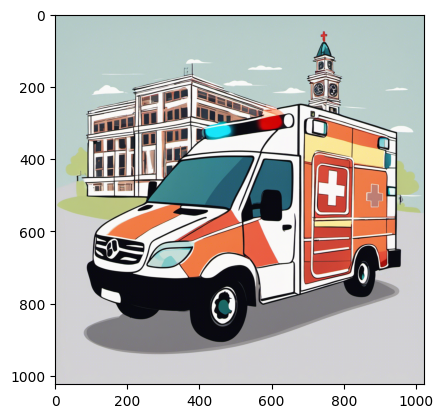

In [7]:
word = "ambulance"
text = "the ambulance was driving fast to the hospital"

prompt = create_prompt_for_image_generation(word, text)

create_static_image(prompt=prompt)

### Testing the images
To test the quality of the generated images and see whether the images could give help explaining the definition of a word, we created 2 tests.

In the first test we presented the image and asked participants to guess what which word the image represents. The participants were given the options to say that they had no idea (*Weet niet*) and to skip an image when they already labelled the image before (*Overslaan*). Guessing proved to be a challenging task.

This a test with an image depicting the word toekomst (future)

![First test showing only an image](https://raw.githubusercontent.com/Tolkie-NL/explanatory-images/main/tolkie-test-image.png)

People entered a total of 870 guesses (or 'No idea's). After these were gathered, we checked and labelled the guesses by comparing them with the intended word. For this we had 4 options:

1. Correct: when the participant entered the correct answer or a synonym of the word
2. Almost: when the participant entered a word that was related to the intended word, but not close enough to be a correct guess.
3. Bad: when the participant entered a word that was not related to the intended word in any way
4. No idea: when the participant entered *weet niet* (no idea)

Some examples for category 2 were entries like 'student' instead of 'education' or 'society' instead of 'everyone'.

Below is a graph with the results of the test

![A circle diagram showing the categories bad (44.6%), no idea (35.2%), almost (14.1%) and correct (6.1%)](https://raw.githubusercontent.com/Tolkie-NL/explanatory-images/main/tolkie-test-image-result.png)

These results show that it's really hard to have images explain words. Our aim was to get a 50 percent score for the test when presenting images without any context. Including the guesses labelled as 'almost' we only reached 20 percent. When going through the list of words, there are a lot of words for which it's hard to create an explanatory image. These words would also be challenging in a game of Pictionary, for example *volgens* (according to), *onderwijs* (education) and *energieverbruik* (energy consumption).

### Experiment 2 ###

After this, a second test wast conducted. The same prompts were used, but participants were given both the image and the sentence the original word was came from. In this sentence the original word was redacted. The test looked like this:

![Second test showing an image and the sentence](https://raw.githubusercontent.com/Tolkie-NL/explanatory-images/main/tolkie-test-image-sentence.png)

It isn't hard to guess that this image represents the word 'museum', although Stable Diffusion still has a hard time adding text to an image and misspelling the word museum. In this test the participants had both the sentence and the generated image to guess the word. Not surprisingly, the results of the test were a lot better.

![A circle diagram with the results of test 2: bad (13.8%), no idea (26.9%), almost (13.7%) and correct (45.6%)](https://raw.githubusercontent.com/Tolkie-NL/explanatory-images/main/tolkie-test-image-sentence-result.png)

The total number of guesses for this test was 804. Here almost half of the words were guessed correctly and 13.7 percent were close. Among the 'bad' and 'no idea' categories were more abstract terms like *helemaal* (totally) and *vervanging* (replacement). However, there were some terms that could have showed better results, like *Russisch* (Russian) and *sloeg* (hit, in past tense).

## What have we learned? ##

Our goal with Tolkie is to help empower people who experience low-literacy to read only texts that would otherwise be hard or impossible to read for them. An important thing to note here is that this group of people doesn't necessarily have a lower iq than other people. They are not dumb. They just haven't been able to develop their ability to read in the required language (yet). People in this group come from all kinds of backgrounds: immigrants or expats who moved to a new country and are still learning the local language, native and proficient speakers who went through the basic levels of education but where their reading skills were falling behind, etc. Because this group generally has the same level of intelligence as the rest of society, we didn't conduct these tests specifically with our target audience. We invited people from different backgrounds to participate.

The fact that image + original sentence scores better than only the image is no surprise. And yes, even without the image some words would be guessed correctly by just providing the sentence. In real life, words are almost always presented in a certain context: on a sign with a symbol, on a page as part of a sentence and paragraph or as part of a headline on a news website. For us the results show that images can help explaining a word. However, not for all images. Even for the best artist, some abstract terms are just nearly impossible to draw. We can't blame Stable Diffusion for that.